In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import shap
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from tensorflow import keras
from tensorflow.keras import layers
import random
from sklearn.metrics import mean_squared_error, mean_absolute_error
from kerastuner.tuners import RandomSearch

## Preparing Data

In [5]:
# Reading in data
crime = pd.read_csv('.\data\Crimes.csv')
weather = pd.read_csv('.\data\weather.csv')
holidays = pd.read_csv('.\data\holidays.csv')
income = pd.read_csv('.\data\med_income.csv')

In [6]:
# date to datetime, creating year column
crime['Date'] = pd.to_datetime(crime['Date']).dt.date
crime['Year'] = pd.to_datetime(crime['Date']).dt.year

# defining violent crimes
violent = ['HOMICIDE', 'BATTERY', 'CRIMINAL SEXUAL ASSAULT', 
           'CRIM SEXUAL ASSAULT', 'ASSAULT', 'ROBBERY', 'HUMAN TRAFFICKING']

# filtering out earlier than 2010, non-violent crimes
crime = crime[(crime['Year'] > 2010) & (crime['Primary Type'].isin(violent))]

In [7]:
# creating count of crimes per day
count = pd.DataFrame(crime.groupby('Date').size().reset_index(name = 'Count'))

In [8]:
# creating year, month, day, weekday columns
count['Year'] = pd.to_numeric(pd.to_datetime(count['Date']).dt.year)
count['Weekday'] = pd.to_numeric(pd.to_datetime(count['Date']).dt.dayofweek)
count['Month'] = pd.to_numeric(pd.to_datetime(count['Date']).dt.month)
count['Day'] = pd.to_numeric(pd.to_datetime(count['Date']).dt.day)

In [9]:
# weather date, sunlight in minutes columns
weather = weather.rename(columns = {'datetime': 'Date'})
weather['Date'] = pd.to_datetime(weather['Date']).dt.date
weather['sunrise'] = (pd.to_datetime(weather['sunrise']))
weather['sunset'] = (pd.to_datetime(weather['sunset']))
weather['sunlight'] = (weather['sunset'] - weather['sunrise']) / pd.Timedelta(minutes = 1)

# holidays date column
holidays['Date'] = (pd.to_datetime(holidays['Date']).dt.date)

# merging datasets based on date (or year for income)
df = pd.merge(count, weather, how = 'left', on = ['Date'])
df = pd.merge(df, holidays, how = 'left', on = ['Date'])
df = pd.merge(df, income, how = 'left', on = ['Year'])

In [10]:
# dropping unnecessary columns
cols = ['description', 'icon', 'stations', 'Day of Week', 'sunrise',
        'sunset', 'name']

df = df.drop(columns = cols)

In [11]:
df.columns

Index(['Date', 'Count', 'Year', 'Weekday', 'Month', 'Day', 'tempmax',
       'tempmin', 'temp', 'feelslikemax', 'feelslikemin', 'feelslike', 'dew',
       'humidity', 'precip', 'precipprob', 'precipcover', 'preciptype', 'snow',
       'snowdepth', 'windgust', 'windspeed', 'winddir', 'sealevelpressure',
       'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex',
       'severerisk', 'moonphase', 'conditions', 'sunlight', 'Holiday',
       'Med_Income'],
      dtype='object')

In [12]:
# numeric and categorical variables
num = df.dtypes[df.dtypes != 'object'].index.to_list()[1:]
cat = df.dtypes[df.dtypes == 'object'].index.to_list()[1:]

In [13]:
# x and y matrices
X = df[num]
y = df['Count']

In [14]:
# splitting into testing/training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Neural Network

In [15]:
# Standardizing the features

# categorical and numeric
# ct = ColumnTransformer([
#     # ('encoder', OneHotEncoder(), cat),
#     ('scaler', StandardScaler(), num)
# ], remainder='passthrough')
# X_train_encoded = ct.fit_transform(X_train)
# X_test_encoded = ct.transform(X_test)
# X_train_encoded = np.array(X_train_encoded).astype('float32')
# X_test_encoded = np.array(X_test_encoded).astype('float32')

# just numeric
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = np.array(X_train_scaled).astype('float32')
X_test_scaled = np.array(X_test_scaled).astype('float32')

In [16]:
# # Define and compile the model
# model = keras.Sequential([
#     layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
#     layers.Dense(64, activation='relu'),
#     layers.Dense(1, activation='linear')
# ])

# model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# # Train the model
# history = model.fit(X_train_scaled, y_train, epochs=100, validation_split=0.2, verbose=0)

# # Evaluate the model
# _, mae = model.evaluate(X_train_scaled, y_test)

# print("Mean Absolute Error:", mae)

In [17]:
# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [18]:
# NN model
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.InputLayer(input_shape=(X_train_scaled.shape[1],)))
    for i in range(hp.Int('num_layers', 1, 5)):
        model.add(layers.Dense(units=hp.Int(f'units_{i}', 32, 512, 32), activation='relu'))
        model.add(layers.Dropout(rate=hp.Float(f'dropout_{i}', 0, 0.5, 0.1)))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
                  loss='mse', metrics=['mae'])
    return model

In [19]:
# random search parameters
tuner = RandomSearch(
    build_model,
    objective='val_mae',
    max_trials=5,
    executions_per_trial=3,
    directory='my_dir',
    project_name='crime_model')

In [20]:
tuner.search(X_train_scaled, y_train, epochs=10, validation_split=0.2)

Trial 4 Complete [00h 00m 09s]
val_mae: 8.23510487874349

Best val_mae So Far: 8.106070359547934
Total elapsed time: 00h 00m 44s

Search: Running Trial #5

Value             |Best Value So Far |Hyperparameter
3                 |5                 |num_layers
384               |320               |units_0
0.3               |0.3               |dropout_0
0.01              |0.0001            |learning_rate
96                |32                |units_1
0.1               |0                 |dropout_1
64                |32                |units_2
0.1               |0                 |dropout_2
192               |32                |units_3
0.3               |0                 |dropout_3
320               |32                |units_4
0.2               |0                 |dropout_4

Epoch 1/10
97/97 [==============================] - 1s 6ms/step - loss: 63.9499 - mae: 6.0566 - val_loss: 27.6759 - val_mae: 4.0276
Epoch 2/10
97/97 [==============================] - 0s 4ms/step - loss: 28.5867 - mae: 

In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
print(best_hyperparameters)

c:\Users\snesl\School\stat486\lab-04-sneslen\.conda\Lib\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
c:\Users\snesl\School\stat486\lab-04-sneslen\.conda\Lib\site-packages\keras\src\saving\saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [ ]:
best_model.fit(X_train_scaled, y_train, epochs=100, validation_split=0.2)

Epoch 1/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 27.3616 - mae: 4.1523 - val_loss: 26.2029 - val_mae: 4.0130
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 27.0679 - mae: 4.1264 - val_loss: 26.2475 - val_mae: 3.9824
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 27.8807 - mae: 4.2376 - val_loss: 26.7453 - val_mae: 3.9999
Epoch 4/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 26.2636 - mae: 4.1031 - val_loss: 26.3907 - val_mae: 3.9825
Epoch 5/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 26.6005 - mae: 4.0957 - val_loss: 26.4724 - val_mae: 3.9874
Epoch 6/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 26.9711 - mae: 4.1193 - val_loss: 26.3323 - val_mae: 3.9784
Epoch 7/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 25.8511 - mae: 4.0592 - val_loss: 26.2091 - val_mae: 3.9908
Epoch 8/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 27.8427 - mae: 4.2310 - val_loss: 26.5186 - val_mae: 3.9898
Epoch 9/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/st

In [ ]:
yhat = best_model.predict(X_train_scaled)
mean_squared_error(y_train, yhat)
mean_absolute_error(y_train, yhat)

121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step


4.089263378363733

## SHAP 

In [ ]:
features = X.columns

In [ ]:
# Training the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
# Creating a SHAP explainer
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

In [ ]:
# exp = shap.Explanation(shap_values[:,:,1], 
#                        shap_values.base_values[:,1], 
#                        X, feature_names=features)

In [ ]:
# shap.plots.waterfall(exp[100])

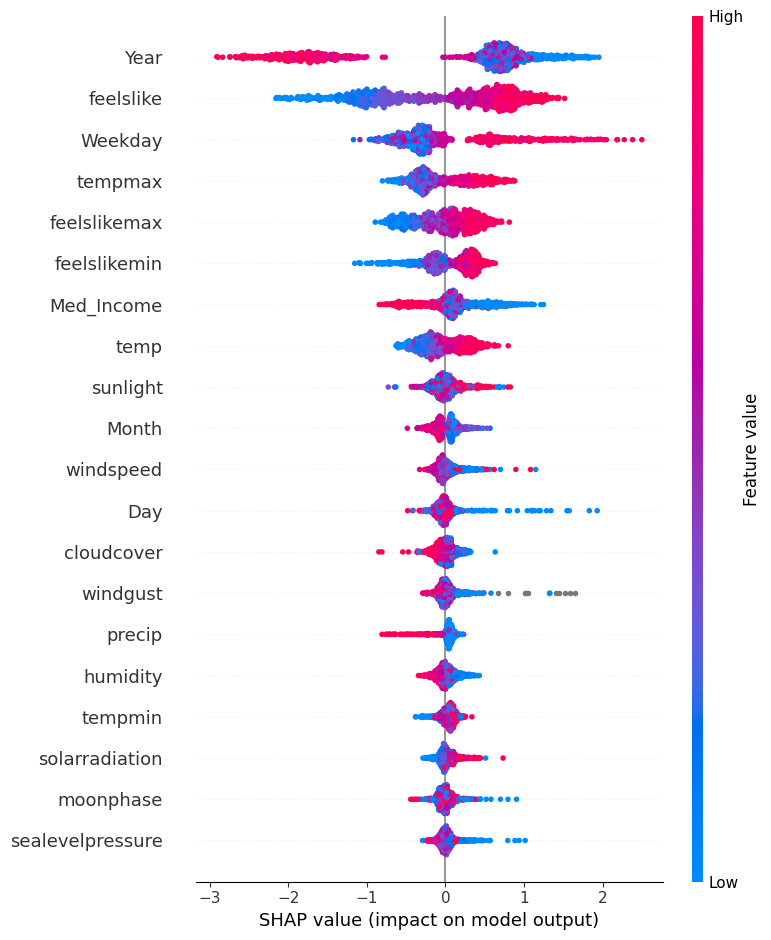

In [ ]:
# Plotting SHAP values
shap.summary_plot(shap_values, X_test)